https://www.kaggle.com/c/titanic/

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import export_graphviz
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz

import warnings
warnings.simplefilter('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [41]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('gender_submission.csv')

In [42]:
display(train.head())
display(test.head())
display(sample_submission.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [43]:
train.shape, test.shape

((891, 12), (418, 11))

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [45]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [46]:
train.Sex.value_counts(dropna=False)

male      577
female    314
Name: Sex, dtype: int64

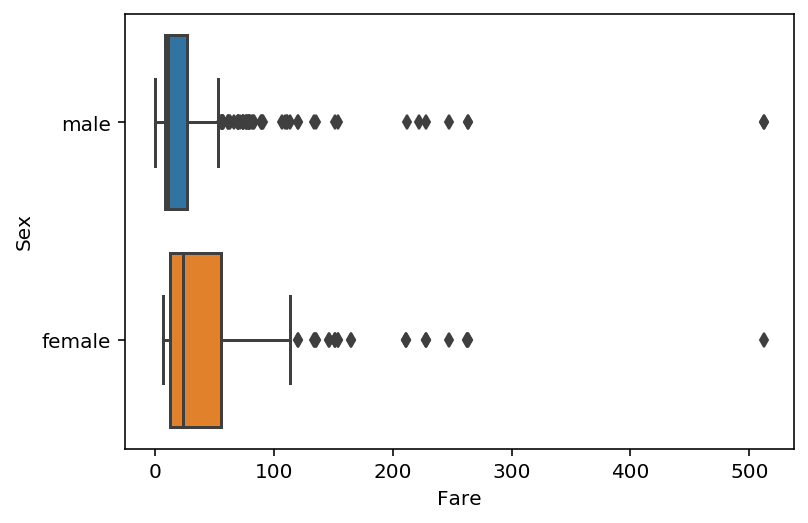

In [47]:
sns.boxplot(data=train, x='Fare', y='Sex');

In [48]:
train.groupby('Sex')['Pclass'].value_counts(normalize=True)

Sex     Pclass
female  3         0.458599
        1         0.299363
        2         0.242038
male    3         0.601386
        1         0.211438
        2         0.187175
Name: Pclass, dtype: float64

In [49]:
y_train = train[['Survived']]
y_train.shape

(891, 1)

In [50]:
X = train[['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']]\
.append(test[['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']])

In [51]:
X['Fare'].fillna(X['Fare'].median(), inplace=True)
X["Sex"] = X["Sex"].map({"male": 1, "female": 0}).astype(int)   

X['Title'] = X['Name'].str.extract(' ([A-Za-z]+)\.')
X['Title'] = X['Title'].replace(['Ms', 'Mlle'], 'Miss')
X['Title'] = X['Title'].replace(['Mme', 'Countess', 'Lady', 'Dona'], 'Mrs')
X['Title'] = X['Title'].replace(['Dr', 'Major', 'Col', 'Sir', 'Rev', 'Jonkheer', 'Capt', 'Don'], 'Mr')

X['Embarked'].fillna('S', inplace=True)
X["Embarked"] = X["Embarked"].map({"S": 1, "C": 2, "Q": 3}).astype(int) 
X['Title'] = X['Title'].map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3}).astype(int) 

In [53]:
X.drop(['Name', 'Ticket'], axis=1, inplace=True)

In [54]:
X.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title
0,3,1,1,0,7.2500,1,0
1,1,0,1,0,71.2833,2,2
2,3,0,0,0,7.9250,1,1
3,1,0,1,0,53.1000,1,2
4,3,1,0,0,8.0500,1,0


In [55]:
X_train = X[0:y_train.shape[0]]
X_test = X[y_train.shape[0]:]

X_train.shape, y_train.shape, X_test.shape

((891, 7), (891, 1), (418, 7))

In [56]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 7), (179, 7), (712, 1), (179, 1))

In [101]:
parameters = {
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 3, 5, 10, None], 
    "min_samples_split": [2, 3, 5, 10],
    "min_samples_leaf": [1, 5, 10, 20]
}

clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

tree_model = GridSearchCV(clf, parameters, cv=5).fit(X_train, y_train)

print(accuracy_score(y_train, tree_model.predict(X_train)))
print(tree_model.best_score_)
print(tree_model.best_params_)
print(tree_model.best_estimator_)

0.8356741573033708
0.8328651685393258
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 2}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [58]:
submission = pd.DataFrame(
    {
        'PassengerId': test['PassengerId'], 
        'Survived': tree_model.predict(X_test) 
    }
)
submission.to_csv("submission_tree.csv", index=False)

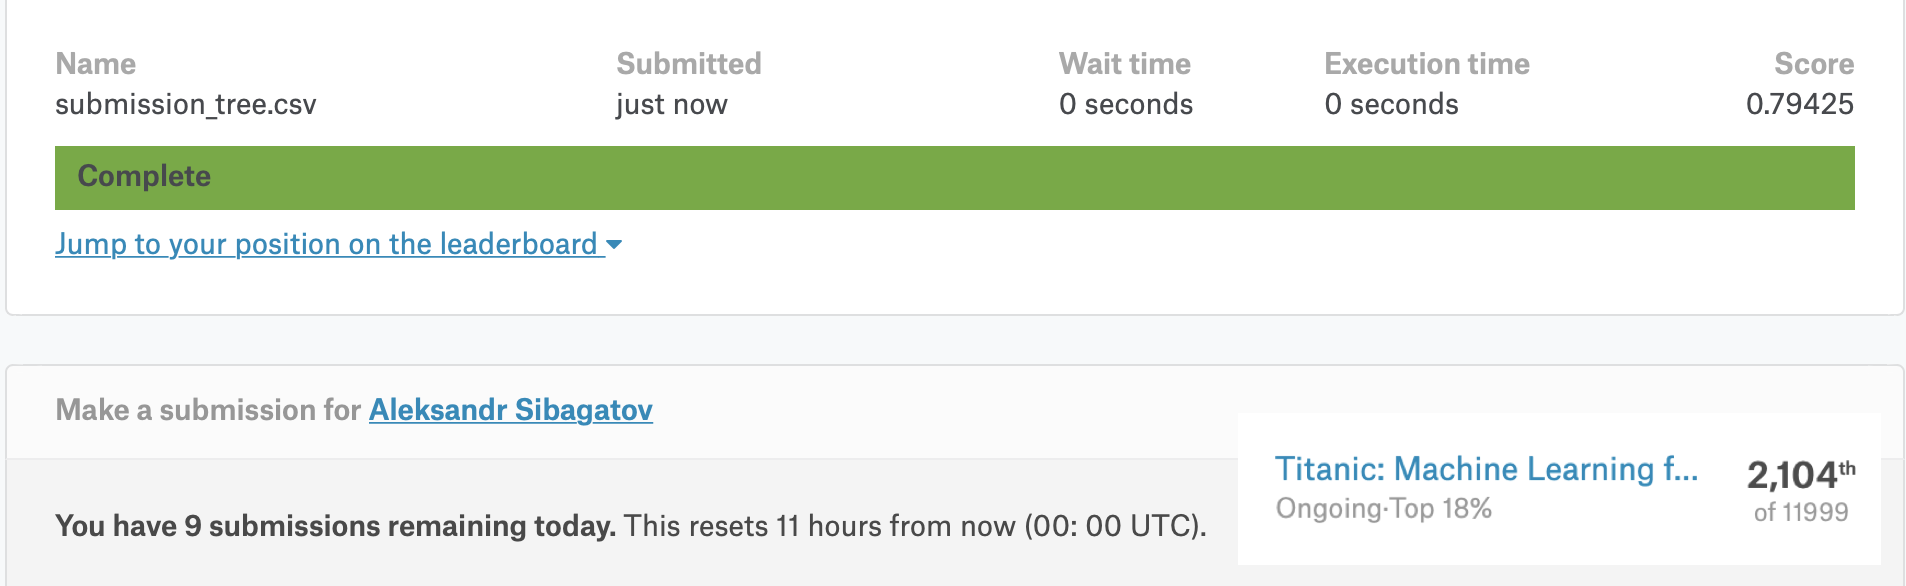

In [60]:
Image('/Users/aleksandr/Desktop/Screenshot 2019-10-15 at 16.25.50.png')

In [89]:
def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [102]:
get_tree_dot_view(clf, list(X_train.columns), ["Not Survived", "Survived"])

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="Title <= 0.5\ngini = 0.473\nsamples = 712\nvalue = [439, 273]\nclass = Not Survived", fillcolor="#f5cfb4"] ;
1 [label="Pclass <= 1.5\ngini = 0.269\nsamples = 430\nvalue = [361, 69]\nclass = Not Survived", fillcolor="#ea995f"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Fare <= 387.665\ngini = 0.442\nsamples = 94\nvalue = [63, 31]\nclass = Not Survived", fillcolor="#f2bf9a"] ;
1 -> 2 ;
3 [label="Fare <= 30.598\ngini = 0.432\nsamples = 92\nvalue = [63, 29]\nclass = Not Survived", fillcolor="#f1bb94"] ;
2 -> 3 ;
4 [label="Fare <= 26.144\ngini = 0.493\nsamples = 34\nvalue = [19, 15]\nclass = Not Survived", fillcolor="#fae4d5"] ;
3 -> 4 ;
5 [label="gini = 0.0\nsamples = 7\nvalue = [7, 0]\nclass = Not Survived", fillcolor="#e58139"] ;
4 -> 5 ;
6 [label="gini = 0.494\nsamples = 27\nvalue = [12, 15]\nclass = Survived", fillcolor="#d7ebfa"] ;
4 -> 6 ;
7 [label="SibSp <= 0.5\ngini = 0.366\nsa

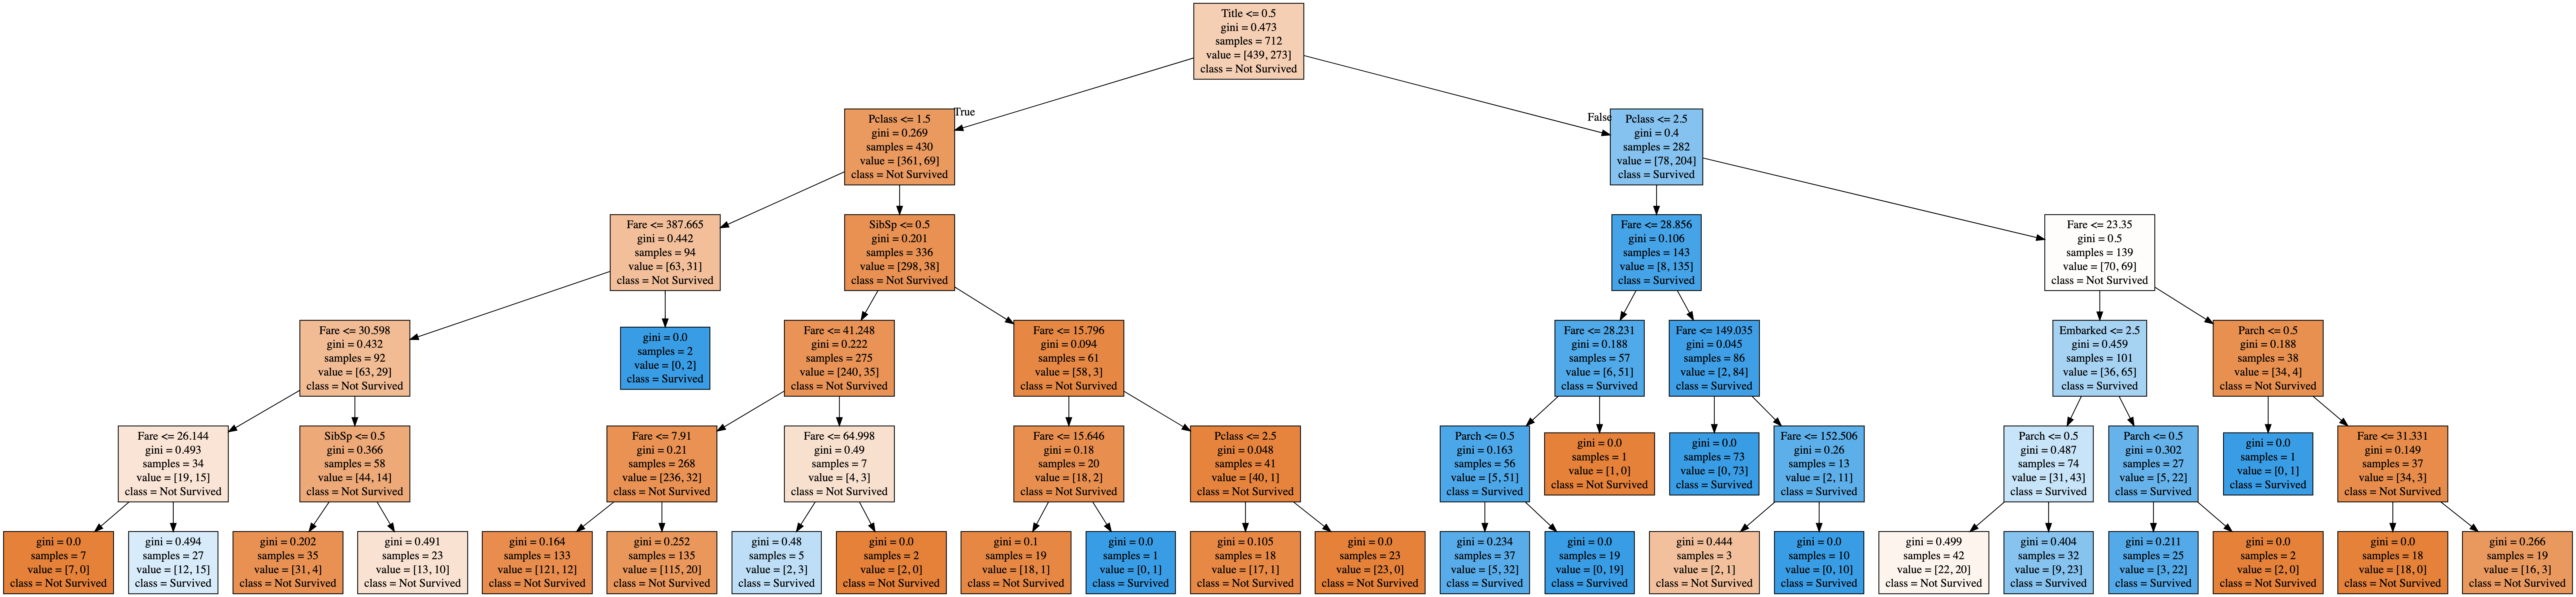

In [103]:
# https://imgur.com/kLBTxG7
Image('/Users/aleksandr/Downloads/downloadGPh.png')

In [ ]:
pass